# Prototyping 1D EFGP 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

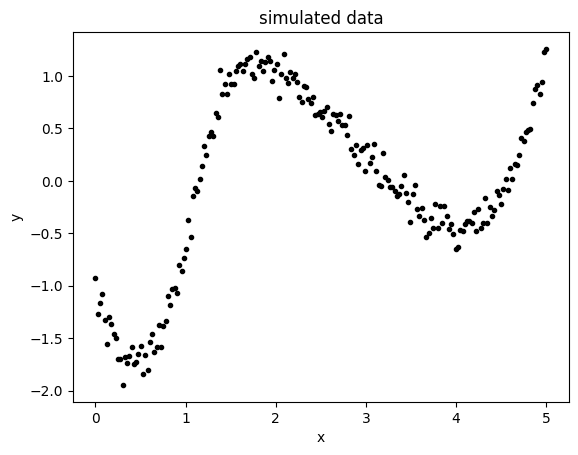

In [ ]:
# generate data 
freq = 0.5    
# 1. Generate synthetic data (or use your data)
n = 200
x = torch.linspace(0, 5, n, dtype=torch.float64)
y = torch.sin(x) + 0.1 * torch.randn(n, dtype=torch.float64) + torch.exp(-x) + 1/10000*torch.exp(2*x) + torch.exp(-4*x) -3*torch.exp(-x**4/2) 
# add a step function to the data
# y[50:100] += 2

# plot data
plt.plot(x, y, 'k.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('simulated data')
plt.show()



In [3]:
N = n


In [4]:
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential

kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)


In [5]:
# Determine problem geometry
L = x[-1] - x[0]
N = x.shape[0]
EPSILON = 1e-5
xis, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)


In [6]:
print("Mtot: ", mtot)
print("h: ", h)
print("xis: ", xis)

Mtot:  97
h:  tensor(0.1809, dtype=torch.float64)
xis:  tensor([-8.6813, -8.5005, -8.3196, -8.1387, -7.9579, -7.7770, -7.5962, -7.4153,
        -7.2344, -7.0536, -6.8727, -6.6919, -6.5110, -6.3301, -6.1493, -5.9684,
        -5.7876, -5.6067, -5.4258, -5.2450, -5.0641, -4.8832, -4.7024, -4.5215,
        -4.3407, -4.1598, -3.9789, -3.7981, -3.6172, -3.4364, -3.2555, -3.0746,
        -2.8938, -2.7129, -2.5321, -2.3512, -2.1703, -1.9895, -1.8086, -1.6277,
        -1.4469, -1.2660, -1.0852, -0.9043, -0.7234, -0.5426, -0.3617, -0.1809,
         0.0000,  0.1809,  0.3617,  0.5426,  0.7234,  0.9043,  1.0852,  1.2660,
         1.4469,  1.6277,  1.8086,  1.9895,  2.1703,  2.3512,  2.5321,  2.7129,
         2.8938,  3.0746,  3.2555,  3.4364,  3.6172,  3.7981,  3.9789,  4.1598,
         4.3407,  4.5215,  4.7024,  4.8832,  5.0641,  5.2450,  5.4258,  5.6067,
         5.7876,  5.9684,  6.1493,  6.3301,  6.5110,  6.6919,  6.8727,  7.0536,
         7.2344,  7.4153,  7.5962,  7.7770,  7.9579,  8.1387,  8

In [7]:
# minus_mh_to_mh = torch.arange(-((mtot-1)/2)*h, ((mtot-1)/2)*h + h)
# print("minus_mh_to_mh: ", minus_mh_to_mh)
# assert torch.allclose(minus_mh_to_mh, xis), "minus_mh_to_mh and xis are not the same"


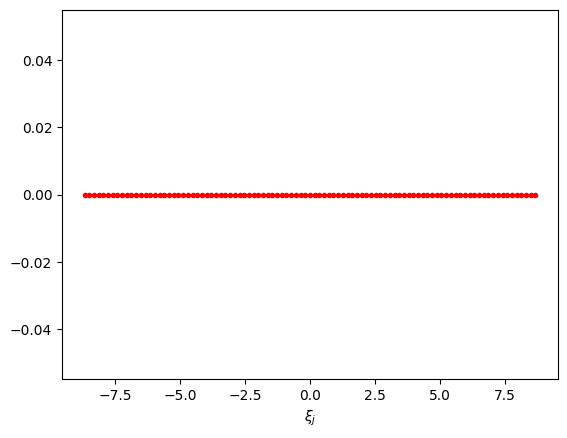

In [8]:
# plot a line with tics on the xis
plt.plot(xis, torch.zeros(mtot), 'r.')
plt.xlabel(r'$\xi_j$')
plt.show()

In [9]:
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h)
D = torch.diag(ws).to(dtype=torch.complex128)

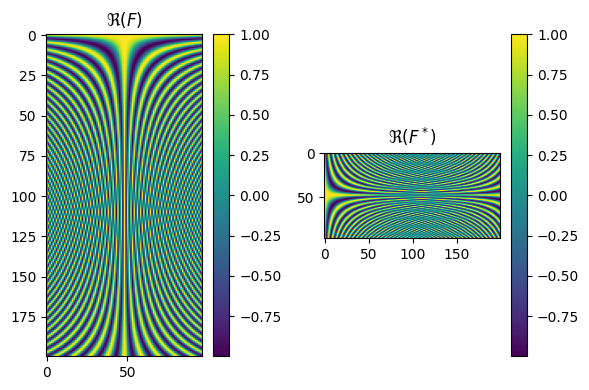

In [10]:
# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT)
F = torch.exp(1j * 2 * torch.pi * torch.outer(x, xis))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

im1 = ax1.imshow(F.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F)$')

im2 = ax2.imshow(F.conj().T.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Re(F^*)$')

plt.tight_layout()
plt.show()

# ws_diag = torch.diag(ws).to(dtype=Phi.dtype) # complex dtype
# A = ws_diag @ (Phi.T @ Phi) @ ws_diag


In [11]:
# create a matrix of distances between x's
dist_matrix = torch.cdist(x.unsqueeze(-1), x.unsqueeze(-1))
kernel_matrix = kernel.kernel(dist_matrix)

In [12]:
ws = ws.to(dtype=torch.complex128)
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))
# right_hand_side = torch.diag(ws) @ (F.adjoint() @ y.to(dtype=torch.complex128))
# beta_test = torch.randn_like(right_hand_side)
# sigmasq = torch.tensor(0.1)
# dense_result = (A + sigmasq * torch.eye(mtot, dtype=A.dtype)) @ beta_test
# from efgp1d import FFTConv1d, compute_convolution_vector_vectorized
# v, j_indices = compute_convolution_vector_vectorized(m=int((mtot - 1) / 2), x=x, h=h)
# Afun = lambda beta: D @ FFTConv1d(v, D @ beta)() + sigmasq * beta
# fft_result = Afun(beta_test)


In [13]:
# print("Dense magnitude:", torch.norm(dense_result))
# print("FFT magnitude:", torch.norm(fft_result))
# print("Dense type:", dense_result.dtype)
# print("FFT type:", fft_result.dtype)

Text(0.5, 0.98, 'Approximating kernel matrix with equispaced features, N = 200, M = 97')

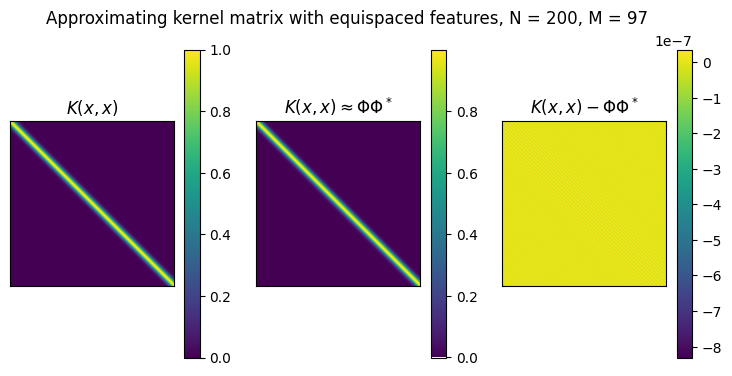

In [14]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')



In [15]:
from efgp_1d_dense import efgp1d_dense
from efgp1d import efgp1d

In [16]:
# make a subset of the data for interpolation and extrapolation
# worked well for N = 200
# x_input = torch.cat([x[:30], x[60:70], x[70:90]])
# y_input = torch.cat([y[:30], y[60:70], y[70:90]])
# for N = 2000
x_input = torch.cat([x[:100], x[300:500], x[650:750]])
y_input = torch.cat([y[:100], y[300:500], y[650:750]])


In [17]:
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta, xis, ytrg, A, F, ws, timing_results = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})

/Users/colecitrenbaum/Documents/GPs/gp-quadrature/efgp_1d_dense.py:87: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:308.)
  logdet = N*torch.log(sigmasq) + torch.logdet((D @ F.adjoint() @ F @ D)/sigmasq + torch.eye(mtot, dtype=torch.float64)).to(dtype=torch.float64)
/Users/colecitrenbaum/Documents/GPs/gp-quadrature/efgp_1d_dense.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4412.)
  log_marg_lik = -0.5 * y.T @ alpha - 0.5 * logdet - 0.5 * N * torch.log(2 * torch.tensor(torch.pi, dtype=torch.float64))


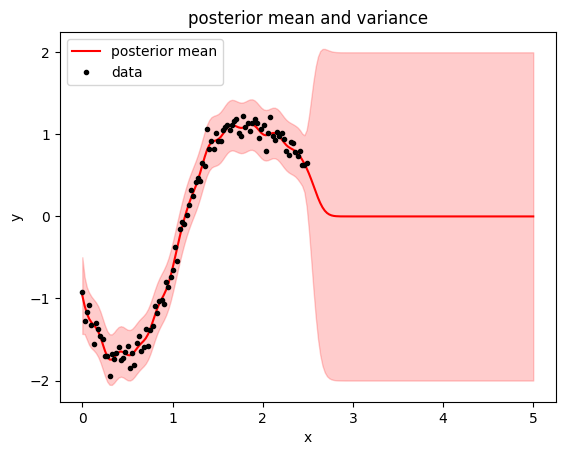

In [18]:
# plot the beta
# plt.plot(x, train_posterior['mean'], 'r-', label='posterior mean')
plt.plot(x, ytrg['mean'], 'r-', label='posterior mean')
# shaded region for +- 2 std
plt.fill_between(x, ytrg['mean'] - 2 * torch.sqrt(ytrg['var']), ytrg['mean'] + 2 * torch.sqrt(ytrg['var']), color='r', alpha=0.2)
plt.plot(x_input, y_input, 'k.', label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('posterior mean and variance')
plt.legend()
plt.show()

In [19]:
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta_cg, xis_cg, ytrg_cg, A_cg, F_cg, ws_cg, timing_results_cg = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cg', 'get_log_marginal_likelihood': True})


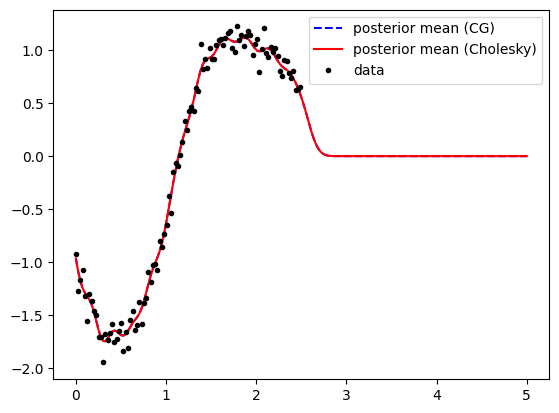

In [20]:
plt.plot(x, ytrg_cg['mean'], 'b--', label='posterior mean (CG)')
plt.plot(x, ytrg['mean'], 'r-', label='posterior mean (Cholesky)')
# plt.fill_between(x, ytrg_cg['mean'] - 2 * torch.sqrt(ytrg_cg['var']), ytrg_cg['mean'] + 2 * torch.sqrt(ytrg_cg['var']), color='b', alpha=0.2)
plt.plot(x_input, y_input, 'k.', label='data')
plt.legend()
plt.show()


In [21]:
assert torch.allclose(ytrg_cg['mean'], ytrg['mean'], atol=1e-8), "ytrg_cg['mean'] and ytrg['mean'] are not the same"

# CG FFT implementation

# hyper opt cole adds

In [22]:
import time
from cg import ConjugateGradients, BatchConjugateGradients

$$\frac{\partial \mathcal L}{\partial \theta} = \frac{1}{2M} \sum_{k=1}^M z_k^T((K + \sigma^2I)^{-1} \frac{\partial (K + \sigma^2 I)}{\partial \theta}) z_k - \frac{1}{2}y^T (K +\sigma^2 I)^{-1}\frac{\partial (K + \sigma^2 I)}{\partial \theta} (K+\sigma^2I)^{-1}y =I - II $$

In [23]:
# # 
# alpha.conj()

In [24]:
xis, h, mtot = get_xis(kernel, 1e-30, L)
print(xis.shape)

torch.Size([239])


In [25]:
# Z = torch.randint(0, 2, (trace_samples, N), dtype=torch.float64) * 2 - 1
# Z.shape

# here is the main gradient approx, not batched 

In [26]:
import torch
import time
import math
from efgp1d import compute_convolution_vector_vectorized, FFTConv1d, BatchFFTConv1d



sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
x_new = x 
num_iters = 1
def efgp1d_gradient(x, y, sigmasq, kernel,eps,trace_samples):
    x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
    y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
    x0, x1 = torch.min(x), torch.max(x)
    # opts = {'get_var': True, 'get_log_marginal_likelihood': True}
    L = x1 - x0
    N = x.shape[0]
    # eps = EPSILON
    # eps = 1e-20

    # Get Fourier frequencies and weights.
    xis, h, mtot = get_xis(kernel, eps, L)  # Expect len(xis)=M (e.g., M=97)
    # Compute weights: ws = sqrt(S(xis)*h)
    ws = torch.sqrt(kernel.spectral_density(xis) * h)  # ws: (M,)
    D = torch.diag(ws).to(dtype=torch.complex128)         # D: (M, M)
    
    # Form design features F (size: (N, M)).
    #TODO : use UFFTConv1d instead of this
    F = torch.exp(1j * 2 * math.pi * torch.outer(x, xis)).to(dtype=torch.complex128)

    v, j_indices = compute_convolution_vector_vectorized(m=int((mtot - 1) / 2), x=x, h=h)
    Afun = lambda beta: D @ FFTConv1d(v, D @ beta)() + sigmasq * beta


    # A = D @ (torch.conj(F).T @ F) @ D  # A: (M, M)
    
    # -------------------
    # Compute term 2: the quadratic form.
    rhs = D @ torch.conj(F).T @ y.to(dtype=torch.complex128)  # rhs: (M,)
    # cg_object = ConjugateGradients(
    #     A_apply_function=A + sigmasq * torch.eye(mtot, dtype=A.dtype),
    #     b=rhs,
    #     x0=torch.zeros_like(rhs),
    #     early_stopping=opts.get('early_stopping', False)
    # )
    cg_object = ConjugateGradients(
        A_apply_function=Afun,
        b=rhs,
        x0=torch.zeros_like(rhs),
        early_stopping=False
        # early_stopping=opts.get('early_stopping', False)
    )
    beta = cg_object.solve()  # beta: (M,)
    alpha = 1/sigmasq * (y - F @ D @ beta)  # alpha: (N,)
    
    # -------------------
    Dprime = h * kernel.spectral_grad(xis)  # shape: (M, n_params)
    # This yields the derivative of the diagonal of D^2, since D^2 = diag(S(xis)*h).
    
    # --- Embed each column of Dprime as a diagonal matrix.
    # Dprime is (M, n_params); we want each column (length M) as an (M,M) diagonal.
    # Transpose so each row corresponds to one hyperparameter:
    Dprime_t = Dprime.transpose(0, 1)   # shape: (n_params, M)
    # Embed each row into a diagonal matrix -> (n_params, M, M)
    D_diag_temp = torch.diag_embed(Dprime_t).to(dtype=torch.complex128)  # shape: (n_params, M, M)
    
    # -------------------
    # Compute khat_prime for the kernel hyperparameters:
    # For each hyperparameter i, we want:
    #     khat_prime_i = F * diag(Dprime_i) * F^*
    # Expand F and its conjugate-transpose to include a batch dimension.
    N_val, M_val = F.shape  # M_val should equal M.
    F_expand = F.unsqueeze(0).expand(D_diag_temp.shape[0], N_val, M_val)  # shape: (n_params, N, M)
    F_adjoint = F.conj().transpose(-2, -1)  # shape: (M, N)
    F_adjoint_expand = F_adjoint.unsqueeze(0).expand(D_diag_temp.shape[0], M_val, N_val)  # shape: (n_params, M, N)
    # Batched multiplication:
    khat_prime_kernel = torch.bmm(torch.bmm(F_expand, D_diag_temp), F_adjoint_expand)  # shape: (n_params, N, N)
    
    # Append the noise derivative (for noise, d/dσ² (K+σ²I) = I) as an extra hyperparameter.
    noise_derivative = torch.eye(N, dtype=khat_prime_kernel.dtype).unsqueeze(0)  # shape: (1, N, N)
    khat_prime_kernel_full = torch.cat([khat_prime_kernel, noise_derivative], dim=0)  # shape: (n_params+1, N, N)
    # Optionally, permute so that the hyperparameter dimension is last:
    khat_prime = khat_prime_kernel_full.permute(1, 2, 0)  # shape: (N, N, n_params+1)
    
    # -------------------
    # Compute term 2 (quadratic term) for each hyperparameter:
    # For hyperparameter i, term2_i = α^* (dK/dθ_i) α.
    term2 = torch.zeros(khat_prime.shape[2], dtype=torch.complex128)
    for i in range(khat_prime.shape[2]):
        term2[i] = torch.matmul(alpha.conj().unsqueeze(0),
                                torch.matmul(khat_prime[:, :, i], alpha.unsqueeze(1))).squeeze()
    
    # -------------------
    # Compute term 1 (trace term) via Monte Carlo.
    # trace_samples = 10
    # try with rademachers instead..

    
    # Z = torch.distributions.multivariate_normal.MultivariateNormal(
    #         loc=torch.zeros_like(x),
    #         covariance_matrix=torch.eye(N, dtype=torch.float64)
    #     ).sample([trace_samples])  # shape: (trace_samples, N)
    # sample Z iid rademacher variables shape (trace_samples, N)
    Z = torch.randint(0, 2, (trace_samples, N), dtype=torch.float64) * 2 - 1
    
    term1 = torch.zeros(khat_prime.shape[2], dtype=torch.complex128)
    for i in range(khat_prime.shape[2]):  # for each hyperparameter derivative
        sum_term1 = 0.0 + 0.0j
#TODO: fix the apply function here 
        for j in range(trace_samples):
            z_sample = Z[j, :].to(dtype=torch.complex128)  # shape: (N,)
            temp_rhs = khat_prime[:, :, i] @ z_sample.unsqueeze(1)  # shape: (N, 1)
            rhs_sample = D @ torch.conj(F).T @ temp_rhs  # shape: (M, 1)
            cg_object = ConjugateGradients(
                A_apply_function=Afun,
                b=rhs_sample.squeeze(),  # shape: (M,)
                x0=torch.zeros_like(rhs_sample.squeeze()),
                early_stopping=False
            )
            beta_sample = cg_object.solve()  # shape: (M,)
            # alpha_sample = 1/sigmasq * (y - F @ D @ beta_sample)  # shape: (N,)
            alpha_sample = 1/sigmasq * (temp_rhs.flatten() - F @ D @ beta_sample)

            sum_term1 += torch.dot(z_sample, alpha_sample)
        term1[i] = sum_term1 / trace_samples

    # -------------------
    # Final gradient for each hyperparameter:
    # grad_i = 0.5 * [ term1_i - term2_i ]
    grad = 0.5 * (term1 - term2)
    return grad.real
    # save the gradients for each loop
    # if iter == 0:
    #     grad_all = grad
    # else:
    #     grad_all = torch.cat([grad_all, grad], dim=0)
    
    # Print the gradients.
grad = efgp1d_gradient(x, y, sigmasq, kernel,EPSILON,trace_samples=10)
for i in range(grad.shape[0]):
    print(f"Hyperparameter {i}: gradient approx = {grad[i].real.item():.6f}")


Hyperparameter 0: gradient approx = -631.501029
Hyperparameter 1: gradient approx = 17.260624
Hyperparameter 2: gradient approx = 671.123853


# batched version

In [27]:
def efgp1d_gradient_batched(x, y, sigmasq, kernel,eps,trace_samples):


    # Ensure x and y are float64 and flattened.
    x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
    y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
    x0, x1 = torch.min(x), torch.max(x)
    L = x1 - x0
    N = x.shape[0]

    # Get Fourier frequencies and quadrature weights.
    xis, h, mtot = get_xis(kernel, eps, L)  # e.g. len(xis)==M, where M=97 for example.

    # Compute weights: ws = sqrt(S(xis) * h)
    ws = torch.sqrt(kernel.spectral_density(xis) * h)  # shape: (M,)
    # We represent D as a diagonal using ws.
    # Convert to complex type.
    ws = ws.to(dtype=torch.complex128)

    # Build design matrix features F: shape (N, M).
    F = torch.exp(1j * 2 * math.pi * torch.outer(x, xis)).to(dtype=torch.complex128)

    # Compute convolution vector v (and indices, if needed).
    v, j_indices = compute_convolution_vector_vectorized(m=int((mtot - 1) / 2), x=x, h=h)
    v = v.to(dtype=torch.complex128)

    # Define the operator for the main linear system.
    # Here, we use FFTConv1d with kernel v and treat D as a diagonal multiplication by ws.
    Afun = lambda beta: ws * BatchFFTConv1d(v, ws * beta)() + sigmasq * beta

    # Solve the main system with your (non-batched) conjugate gradient solver.
    rhs = ws * (torch.conj(F).T @ y.to(dtype=torch.complex128))  # shape: (M,)
    cg_object = ConjugateGradients(
        A_apply_function=Afun,
        b=rhs,
        x0=torch.zeros_like(rhs),
        early_stopping=False
    )
    beta = cg_object.solve()  # beta: (M,)
    alpha = 1/sigmasq * (y - F @ (ws * beta))  # shape: (N,)

    ##############################################
    # Compute Hyperparameter Gradients
    ##############################################
    # 1. Compute the derivative of the diagonal of D².
    Dprime = h * kernel.spectral_grad(xis)  # shape: (M, n_params)
    # Embed each column as a diagonal matrix.
    Dprime_t = Dprime.transpose(0, 1)  # shape: (n_params, M)
    D_diag_temp = torch.diag_embed(Dprime_t).to(dtype=torch.complex128)  # shape: (n_params, M, M)

    # 2. Compute khat_prime for kernel hyperparameters:
    #    khat_prime = F @ diag(Dprime_i) @ F^H for each hyperparameter i.
    N_val, M_val = F.shape  # (N, M)
    F_expand = F.unsqueeze(0).expand(D_diag_temp.shape[0], N_val, M_val)  # (n_params, N, M)
    F_adjoint = torch.conj(F).transpose(-2, -1)  # (M, N)
    F_adjoint_expand = F_adjoint.unsqueeze(0).expand(D_diag_temp.shape[0], M_val, N_val)  # (n_params, M, N)
    khat_prime_kernel = torch.bmm(torch.bmm(F_expand, D_diag_temp), F_adjoint_expand)  # (n_params, N, N)
    # Append the noise derivative (for σ², the derivative is I)
    noise_derivative = torch.eye(N, dtype=khat_prime_kernel.dtype, device=khat_prime_kernel.device).unsqueeze(0)  # (1, N, N)
    khat_prime_kernel_full = torch.cat([khat_prime_kernel, noise_derivative], dim=0)  # (n_params+1, N, N)
    # Permute so that hyperparameter derivative dimension is last.
    khat_prime = khat_prime_kernel_full.permute(1, 2, 0)  # shape: (N, N, n_params+1)

    # 3. Compute the quadratic form term2 for each hyperparameter:
    term2 = torch.zeros(khat_prime.shape[2], dtype=torch.complex128, device=khat_prime.device)
    for i in range(khat_prime.shape[2]):
        term2[i] = (torch.conj(alpha).unsqueeze(0) @ (khat_prime[:, :, i] @ alpha.unsqueeze(1))).squeeze()

    ##############################################
    # Monte Carlo Trace Term (term1) using Batch CG solver
    ##############################################
    # Create trace_samples Rademacher vectors. (Each entry is +1 or -1.)
    Z = torch.randint(0, 2, (trace_samples, N), dtype=torch.float64, device=x.device) * 2 - 1  # shape: (trace_samples, N)
    Z = Z.to(dtype=torch.complex128)  # cast to complex for consistency

    # Define a batched operator based on FFTConv1d for use in the CG solver.
    def Afun_batch(beta):
        """
        Batched operator acting on beta of shape (B, M).
        Returns: ws * FFTConv1d(v, ws * beta)() + sigmasq * beta, shape (B, M).
        """
        # Multiply beta by ws elementwise (equivalent to a diagonal D multiplication)
        D_beta = ws * beta
        # FFTConv1d expects the second argument to have shape (B, L); ensure beta is batched.
        conv_result = BatchFFTConv1d(v, D_beta)()  # Output shape: (B, M) if beta is (B, M)
        return ws * conv_result + sigmasq * beta

    # We'll now loop over each hyperparameter derivative index;
    # for each, we form a batched right-hand side (one per trace sample), solve the linear systems in batch,
    # and compute the corresponding trace term.
    term1 = torch.zeros(khat_prime.shape[2], dtype=torch.complex128, device=khat_prime.device)

    for i in range(khat_prime.shape[2]):
        # For the i-th hyperparameter derivative, get A_i = (khat_prime)_i  of shape (N, N).
        A_i = khat_prime[:, :, i]  # (N, N)
        # Expand A_i into a batch to multiply with each Rademacher sample.
        A_i_batch = A_i.unsqueeze(0).expand(trace_samples, -1, -1)  # (trace_samples, N, N)
        
        # Reshape Z so that each sample is a column vector.
        z_batch = Z.unsqueeze(-1)  # (trace_samples, N, 1)
        # Compute the right-hand side for each trace sample: temp_rhs = A_i @ z.
        temp_rhs_batch = torch.bmm(A_i_batch, z_batch)  # (trace_samples, N, 1)
        
        # Next, form the right-hand side for the linear system:
        # b_batch = ws * (F^H @ temp_rhs).
        # Compute F^H @ temp_rhs for each sample.
        # Note: F^H = conj(F)^T. temp_rhs_batch: (trace_samples, N, 1), so we need to reshape F^H.
        inner = torch.matmul(temp_rhs_batch.squeeze(-1), torch.conj(F))  # (trace_samples, M)
        b_batch = ws * inner  # (trace_samples, M)
        
        # Solve A x = b for all trace samples using the Batch CG solver.
        cg_solver = BatchConjugateGradients(
            A_apply_function=Afun_batch,
            b=b_batch,
            x0=torch.zeros_like(b_batch),
            tol=1e-6,
            early_stopping=False
        )
        beta_batch = cg_solver.solve()  # (trace_samples, M)
        
        # Compute F @ (ws * beta_batch) for each trace sample.
        D_beta_batch = ws * beta_batch  # (trace_samples, M)
        F_expanded = F.unsqueeze(0).expand(trace_samples, -1, -1)  # (trace_samples, N, M)
        F_beta = torch.bmm(F_expanded, D_beta_batch.unsqueeze(-1)).squeeze(-1)  # (trace_samples, N)
        
        # Compute the corresponding alpha for each trace sample:
        # alpha_batch = 1/sigmasq * (temp_rhs - F @ (ws * beta_batch))
        temp_rhs_flat = temp_rhs_batch.squeeze(-1)  # (trace_samples, N)
        alpha_batch = 1/sigmasq * (temp_rhs_flat - F_beta)  # (trace_samples, N)
        
        # Now, compute the dot product z^T * alpha for each trace sample and average.
        dots = torch.sum(Z * alpha_batch, dim=1)  # (trace_samples,)
        term1[i] = torch.mean(dots)

    ##############################################
    # Final Hyperparameter Gradients
    ##############################################
    grad = 0.5 * (term1 - term2)
    grad = grad.real  # if only the real parts are desired
    # print("Gradient for hyperparameters:", grad)

    return grad
grad = efgp1d_gradient_batched(x, y, sigmasq, kernel,EPSILON,trace_samples=10)
for i in range(grad.shape[0]):
    print(f"Hyperparameter {i}: gradient approx = {grad[i].real.item():.6f}")


Hyperparameter 0: gradient approx = -595.968989
Hyperparameter 1: gradient approx = 14.350855
Hyperparameter 2: gradient approx = 700.221537


In [28]:
# grad_all = grad_all.reshape(num_iters,3).real
# # make separate boxplots for each gradient
# # make subplots
# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs[2].boxplot(grad_all[:, 2], positions=[0], widths=0.4, label='noise')
# axs[2].set_title('noise')
# axs[2].set_xticks([])
# axs[1].boxplot(grad_all[:, 1], positions=[0], widths=0.4, label='variance')
# axs[1].set_title('variance')
# axs[1].set_xticks([])
# axs[0].boxplot(grad_all[:, 0], positions=[0], widths=0.4, label='lengthscale')
# axs[0].set_title('length scale')
# axs[0].set_xticks([])
# axs[0].set_ylabel('Gradient')
# plt.suptitle('Boxplots of gradients for each hyperparameter')
# # add lines from true gradients
# # true gradients
# # true_grad = torch.tensor([-0.0001, -0.0001, -0.0001])
# true_grad=  true_grad.real
# # axs[0].axhline(y=true_grad[0], color='r', linestyle='--')
# # axs[1].axhline(y=true_grad[1], color='r', linestyle='--')
# axs[2].axhline(y=true_grad[2], color='r', linestyle='--', label=f'True: {true_grad[2]:.4f}')
# axs[2].legend()
# axs[1].axhline(y=true_grad[1], color='r', linestyle='--', label=f'True: {true_grad[1]:.4f}')
# axs[1].legend()
# axs[0].axhline(y=true_grad[0], color='r', linestyle='--', label=f'True: {true_grad[0]:.4f}')
# axs[0].legend()
# # add legend
# plt.tight_layout()




# direct inversion using the fourier approximation 
- very similar to auto grad

In [29]:
import torch
import math

def compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON):
    # sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
    # kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

    # Flatten data to 1D.
    x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
    y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
    x_new = torch.linspace(0, 5, 1000, dtype=torch.float64)

    # Problem geometry.
    x0 = torch.min(x)
    x1 = torch.max(x)
    L_val = x1 - x0
    N = x.shape[0]
    eps = EPSILON
    # eps = 1e-2

    # Get Fourier frequencies and quadrature weights.
    xis, h, mtot = get_xis(kernel, eps, L_val)  # Expect len(xis)=M
    M = len(xis)

    # Compute spectral density and weights.
    # ws = sqrt(S(xis)*h) so that D^2 = diag(S(xis)*h)
    ws = torch.sqrt(kernel.spectral_density(xis) * h)  # shape: (M,)
    D = torch.diag(ws).to(dtype=torch.complex128)         # D: (M, M)

    # Form design features F (N x M): F[n,m] = exp(2pi i * xis[m] * x[n])
    F = torch.exp(1j * 2 * math.pi * torch.outer(x, xis)).to(dtype=torch.complex128)

    # Compute approximate kernel: K = F * D^2 * F^*.
    D2 = D @ D  # This is just diag(ws^2)
    K = F @ D2 @ F.conj().transpose(-2, -1)  # shape: (N, N)
    C = K + sigmasq * torch.eye(N, dtype=torch.complex128)  # add noise term

    # Directly invert C and compute alpha.
    C_inv = torch.linalg.inv(C)
    alpha = C_inv @ y.to(dtype=torch.complex128)  # shape: (N,)

    # Compute derivative of the kernel with respect to the kernel hyperparameters.
    # Let spectral_grad = kernel.spectral_grad(xis), shape: (M, n_params)
    spectral_grad = kernel.spectral_grad(xis)  # shape: (M, n_params)
    # Then dK/dtheta for each kernel hyperparameter i is approximated as:
    # dK/dtheta_i = F * diag( h * spectral_grad(:, i) ) * F^*
    dK_dtheta_list = []
    n_params = spectral_grad.shape[1]
    for i in range(n_params):
        dK_i = F @ torch.diag((h * spectral_grad[:, i]).to(dtype=torch.complex128)) @ F.conj().transpose(-2, -1)
        dK_dtheta_list.append(dK_i)
    # The derivative with respect to the noise parameter is simply the identity.
    dK_dtheta_list.append(torch.eye(N, dtype=torch.complex128))
    n_total = n_params + 1

    # Compute gradient for each hyperparameter using:
    # grad = 0.5 * [trace(C_inv * dK/dtheta) - alpha^H * (dK/dtheta) * alpha]
    grad = torch.zeros(n_total, dtype=torch.complex128)
    for i in range(n_total):
        if i < n_params:
            term1 = torch.trace(C_inv @ dK_dtheta_list[i])
            term2 = (alpha.conj().unsqueeze(0) @ (dK_dtheta_list[i] @ alpha.unsqueeze(1))).squeeze()
        else:  # noise derivative: dC/d(sigmasq) = I
            term1 = torch.trace(C_inv)
            term2 = (alpha.conj().unsqueeze(0) @ alpha.unsqueeze(1)).squeeze()
        grad[i] = 0.5 * (term1 - term2)
        # print('term1:' ,term1.real)
        # print('term2:', term2.real) 

    # Print the gradients (real parts)
    print("(Truncated) Direct inversion gradient:")
    print(f"  dNLL/d(lengthscale) = {grad[0].real.item():.6f}")
    if n_params > 1:
        print(f"  dNLL/d(variance)    = {grad[1].real.item():.6f}")
    print(f"  dNLL/d(noise)       = {grad[-1].real.item():.6f}")
    true_grad = grad.clone()
    print("term 1: ", term1.real, "term 2: ", term2.real)
    return true_grad.real
true_grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)

(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -600.151607
  dNLL/d(variance)    = 15.996114
  dNLL/d(noise)       = 683.768948
term 1:  tensor(1517.6070, dtype=torch.float64) term 2:  tensor(150.0691, dtype=torch.float64)


# auto diff, full kernel, no approximations

In [30]:
kernel.kernel_matrix(x,x)

tensor([[1.0000, 0.9689, 0.8814,  ..., 0.0000, 0.0000, 0.0000],
        [0.9689, 1.0000, 0.9689,  ..., 0.0000, 0.0000, 0.0000],
        [0.8814, 0.9689, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.9689, 0.8814],
        [0.0000, 0.0000, 0.0000,  ..., 0.9689, 1.0000, 0.9689],
        [0.0000, 0.0000, 0.0000,  ..., 0.8814, 0.9689, 1.0000]],
       dtype=torch.float64)

In [31]:
sigmasq

tensor(0.1000, dtype=torch.float64)

In [32]:
# 3. Define the squared-exponential kernel.
def squared_exponential_kernel(x1, x2, lengthscale, variance):
    # Ensure inputs are 2D
    if x1.dim() == 1:
        x1 = x1.unsqueeze(1)
    if x2.dim() == 1:
        x2 = x2.unsqueeze(1)
    # Compute pairwise squared Euclidean distances.
    diff = x1.unsqueeze(1) - x2.unsqueeze(0)   # shape: (n1, n2, d)
    dist_sq = (diff ** 2).sum(dim=2)             # shape: (n1, n2)
    K = variance * torch.exp(-0.5 * dist_sq / (lengthscale ** 2))
    return K

# -------------------------
# 4. Define the negative log marginal likelihood (NLL)
def negative_log_marginal_likelihood(x, y, lengthscale, variance, noise):
    if x.dim() == 1:
        x = x.unsqueeze(1)
    if y.dim() == 1:
        y = y.unsqueeze(1)
    n = x.shape[0]
    # Compute kernel matrix K(X,X) and add noise on the diagonal.
    K = squared_exponential_kernel(x, x, lengthscale, variance) + noise * torch.eye(n, dtype=torch.float64)
    # Compute Cholesky factorization of K.
    L = torch.linalg.cholesky(K)
    # Solve for alpha = K^{-1} y using the Cholesky factors.
    alpha = torch.cholesky_solve(y, L)
    # Compute the log determinant of K via its Cholesky factor.
    logdetK = 2 * torch.sum(torch.log(torch.diag(L)))
    # NLL = 0.5 * y^T K^{-1} y + 0.5 * log|K| + 0.5*n*log(2π)
    nll = 0.5 * torch.matmul(y.T, alpha) + 0.5 * logdetK + 0.5 * n * math.log(2 * math.pi)
    return nll.squeeze()  # return a scalar
def compute_gradients_vanilla(x, y, sigmasq, kernel):
    if x.ndim == 1:
        x = x.unsqueeze(-1)
    if y.ndim == 1:
        y = y.unsqueeze(-1)


    # -------------------------
    # 2. Define hyperparameters as torch tensors with gradients.
    lengthscale = torch.tensor(kernel.lengthscale, dtype=torch.float64, requires_grad=True)
    variance    = torch.tensor(kernel.variance, dtype=torch.float64, requires_grad=True)
    noise       = sigmasq.clone().detach().requires_grad_(True)

    # -------------------------


    # -------------------------
    # 5. Compute the NLL and its gradients.
    nll = negative_log_marginal_likelihood(x, y, lengthscale, variance, noise)
    print("Negative log marginal likelihood:", nll.item())

    nll.backward()

    print("\n (VANILLA) Gradients of the negative log marginal likelihood:")
    print("  dNLL/d(lengthscale) =", lengthscale.grad.item())
    print("  dNLL/d(variance)    =", variance.grad.item())
    print("  dNLL/d(noise)       =", noise.grad.item())
    grad = torch.tensor([lengthscale.grad.item(), variance.grad.item(), noise.grad.item()])

    return grad.to(dtype=torch.float64)
grad = compute_gradients_vanilla(x, y, sigmasq, kernel)


Negative log marginal likelihood: 49.14672844498884

 (VANILLA) Gradients of the negative log marginal likelihood:
  dNLL/d(lengthscale) = -600.1607383547528
  dNLL/d(variance)    = 15.996143643910338
  dNLL/d(noise)       = 683.7687106446815


In [33]:
grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)

(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -600.151607
  dNLL/d(variance)    = 15.996114
  dNLL/d(noise)       = 683.768948
term 1:  tensor(1517.6070, dtype=torch.float64) term 2:  tensor(150.0691, dtype=torch.float64)


In [34]:
grad

tensor([-600.1516,   15.9961,  683.7689], dtype=torch.float64)

In [35]:
grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)

(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -600.151607
  dNLL/d(variance)    = 15.996114
  dNLL/d(noise)       = 683.768948
term 1:  tensor(1517.6070, dtype=torch.float64) term 2:  tensor(150.0691, dtype=torch.float64)


In [36]:
kernel = SquaredExponential(dimension=1, lengthscale=10, variance=0.01)

grad_trunc = compute_gradients_truncated(x, y, sigmasq, kernel, 1e-20)
grad_vanilla = compute_gradients_vanilla(x, y, sigmasq, kernel)
torch.allclose(grad_trunc,grad_vanilla)


(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = 3.922837
  dNLL/d(variance)    = -1998.145233
  dNLL/d(noise)       = -5987.706418
term 1:  tensor(1987.5669, dtype=torch.float64) term 2:  tensor(13962.9797, dtype=torch.float64)
Negative log marginal likelihood: 673.9655908611384

 (VANILLA) Gradients of the negative log marginal likelihood:
  dNLL/d(lengthscale) = 3.92283739068597
  dNLL/d(variance)    = -1998.1452326556532
  dNLL/d(noise)       = -5987.706418040039


True

In [37]:
efgp1d_gradient(x, y, sigmasq, kernel,EPSILON,trace_samples=10)

tensor([ 3.9295e+00, -1.9976e+03, -5.9878e+03], dtype=torch.float64)

In [38]:
kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
grad = efgp1d_gradient(x, y, sigmasq, kernel, EPSILON, trace_samples=10)


In [39]:
grad

tensor([-609.9234,   16.6206,  677.5243], dtype=torch.float64)

In [40]:
kernel

SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

In [41]:
grad

tensor([-609.9234,   16.6206,  677.5243], dtype=torch.float64)

In [42]:
lr = 0.01

In [43]:
# perform boring SGD using efgp1d_gradient and track hyperparameters
epsilon_values = [1e-2]
# trace_samples_values = [1,10, 50]
trace_samples_values  = [5,10,50]

results = []
max_iters = 50
for epsilon in epsilon_values:
    for trace_samples in trace_samples_values:
        kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
        sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
        log_marginals = []
        tracked_lengthscales = []
        tracked_variances = []
        tracked_noises = []

        for iter in range(max_iters):  # Perform 20 iterations of SGD
            # grad = efgp1d_gradient(x, y, sigmasq, kernel, epsilon, trace_samples=trace_samples)
            grad = efgp1d_gradient_batched(x, y, sigmasq, kernel, epsilon, trace_samples=trace_samples)
            kernel.lengthscale = np.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])
            kernel.variance = np.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])
            lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
            sigmasq = torch.exp(lognoise)
            # sigmasq = sigmasq - 0.0001 * grad[2]

            # Track hyperparameters
            tracked_lengthscales.append(kernel.lengthscale.item())
            tracked_variances.append(kernel.variance.item())
            tracked_noises.append(sigmasq.item())

            beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=epsilon, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
            log_marginals.append(kernel.log_marginal(x, y, sigmasq))
            if iter % 10 == 0:
                print(f"Epsilon {epsilon}, Trace samples {trace_samples}, Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale.item()}, variance = {kernel.variance.item()}, noise = {sigmasq.item()}")

            if torch.norm(grad) < 1e-5:
                print(f"Gradient is small at iteration {iter}. Stopping early.")
                break
        # Store results for this epsilon and trace_samples value
        results.append({
            'epsilon': epsilon,
            'trace_samples': trace_samples,
            'log_marginals': log_marginals,
            'tracked_lengthscales': tracked_lengthscales,
            'tracked_variances': tracked_variances,
            'tracked_noises': tracked_noises,
            'iters': iter
        })
# # Perform training over 3 different values of trace samples

# for trace_samples in trace_samples_values:
#     kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
#     lr = 0.01
#     log_marginals = []
#     tracked_lengthscales = []
#     tracked_variances = []
#     tracked_noises = []

#     for iter in range(20):  # Perform 20 iterations of SGD
#         grad = efgp1d_gradient(x, y, sigmasq, kernel, EPSILON, trace_samples=trace_samples)
#         kernel.lengthscale = kernel.lengthscale - lr * grad[0]
#         kernel.variance = kernel.variance - lr * grad[1]
#         # sigmasq = sigmasq - 0.0001 * grad[2]

#         # Track hyperparameters
#         tracked_lengthscales.append(kernel.lengthscale.item())
#         tracked_variances.append(kernel.variance.item())
#         tracked_noises.append(sigmasq.item())

#         beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
#         log_marginals.append(kernel.log_marginal(x, y, sigmasq))
#         if iter % 10 == 0:
#             print(f"Trace samples {trace_samples}, Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale.item()}, variance = {kernel.variance.item()}, noise = {sigmasq.item()}")

#     # Store results for this trace_samples value
#     results.append({
#         'trace_samples': trace_samples,
#         'log_marginals': log_marginals,
#         'tracked_lengthscales': tracked_lengthscales,
#         'tracked_variances': tracked_variances,
#         'tracked_noises': tracked_noises
#     })
# kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
# lr = 0.01
# log_marginals = []
# true_logmarginal = []
# tracked_lengthscales = []
# tracked_variances = []
# tracked_noises = []

# for iter in range(20):  # Perform 50 iterations of SGD
#     grad = efgp1d_gradient(x, y, sigmasq, kernel, EPSILON, trace_samples=10)
#     kernel.lengthscale = kernel.lengthscale - lr * grad[0]
#     kernel.variance = kernel.variance - lr * grad[1]
#     # sigmasq = sigmasq - 0.0001 * grad[2]

#     # Track hyperparameters
#     tracked_lengthscales.append(kernel.lengthscale.item())
#     tracked_variances.append(kernel.variance.item())
#     tracked_noises.append(sigmasq.item())

#     beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
#     # log_marginals.append(ytrg['log_marginal_likelihood'].item())
#     log_marginals.append(kernel.log_marginal(x, y, sigmasq))
#     if iter % 10 == 0:
#         print(f"Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale.item()}, variance = {kernel.variance.item()}, noise = {sigmasq.item()}")

# # for iter in range(50):  # Perform 100 iterations of SGD
# #     grad = efgp1d_gradient(x, y, sigmasq, kernel, EPSILON, trace_samples=10)
# #     kernel.lengthscale = kernel.lengthscale - lr * grad[0]
# #     kernel.variance = kernel.variance - lr * grad[1]
# #     sigmasq - sigmasq + lr * grad[2]

# #     beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
# #     log_marginals.append(ytrg['log_marginal_likelihood'].item())
# #     if iter % 10 == 0:
# #         print(f"Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale.item()}, variance = {kernel.variance.item()}, noise = {sigmasq.item()}")


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/1257500722.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kernel.lengthscale = np.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/1257500722.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kernel.variance = np.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])
/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/torch/autograd/profiler.py:266: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


Epsilon 0.01, Trace samples 5, Iteration 0: log marginal = 29.867186119518635, grad = tensor([-621.5396,   20.0325,  643.3390], dtype=torch.float64), lengthscale = 0.18617923179640328, variance = 0.8184646266973912, noise = 0.05255347243206732
Epsilon 0.01, Trace samples 5, Iteration 10: log marginal = 136.27734850013596, grad = tensor([ 21.2757,  -5.6296, 233.6564], dtype=torch.float64), lengthscale = 0.5825475126701695, variance = 0.8212019146046377, noise = 0.010424921626799909
Epsilon 0.01, Trace samples 5, Iteration 20: log marginal = 136.89227528537876, grad = tensor([-38.6961,   2.1709,  34.2081], dtype=torch.float64), lengthscale = 0.6706954714118422, variance = 0.922745865194515, noise = 0.010535673611642933
Epsilon 0.01, Trace samples 5, Iteration 30: log marginal = 135.87748655857902, grad = tensor([  7.0155,   0.6706, 147.5235], dtype=torch.float64), lengthscale = 0.5628238160069929, variance = 1.0330062809563911, noise = 0.01043894717328506
Epsilon 0.01, Trace samples 5, I

In [44]:
kernel

SquaredExponential(dimension=1, lengthscale=tensor(0.7079, dtype=torch.float64), variance=tensor(1.3484, dtype=torch.float64))

In [45]:
grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
grad_trunc = compute_gradients_truncated(x, y, sigmasq, kernel, 1e-30)
torch.allclose(grad_trunc,grad)

Negative log marginal likelihood: -137.26503222114965

 (VANILLA) Gradients of the negative log marginal likelihood:
  dNLL/d(lengthscale) = 0.727819684286465
  dNLL/d(variance)    = -0.37409777355592055
  dNLL/d(noise)       = 20.068730316588812
(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = 0.727820
  dNLL/d(variance)    = -0.374098
  dNLL/d(noise)       = 20.068730
term 1:  tensor(17867.1782, dtype=torch.float64) term 2:  tensor(17827.0408, dtype=torch.float64)


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/2591063631.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengthscale = torch.tensor(kernel.lengthscale, dtype=torch.float64, requires_grad=True)
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/2591063631.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  variance    = torch.tensor(kernel.variance, dtype=torch.float64, requires_grad=True)


True

In [46]:
grad[1]

tensor(-0.3741, dtype=torch.float64)

In [47]:
# perform sgd on the vanilla kernel 
kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
log_marginals = []
tracked_lengthscales_vanilla = []
tracked_variances_vanilla = []
tracked_noises_vanilla = []
for iter in range(max_iters):  # Perform 20 iterations of SGD
    grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
    # kernel.lengthscale = kernel.lengthscale - lr * grad[0]
    kernel.lengthscale = np.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])    
    kernel.variance = np.exp(np.log(kernel.variance) - lr * kernel.variance * grad[1])
    # kernel.variance = np.exp(np.log(kernel.variance) - lr * kernel.variance * grad[1])

    lognoise = torch.log(sigmasq) - lr * sigmasq * grad[2]
    sigmasq = torch.exp(lognoise)

    # Track hyperparameters
    tracked_lengthscales_vanilla.append(kernel.lengthscale.item())
    tracked_variances_vanilla.append(kernel.variance.item())
    tracked_noises_vanilla.append(sigmasq.item())

    beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
    log_marginals.append(kernel.log_marginal(x, y, sigmasq))
    if iter % 10 == 0:
        print(f"Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale.item()}, variance = {kernel.variance.item()}, noise = {sigmasq.item()}")
            # break if grad is small
    if torch.norm(grad) < 1e-5:
        print(f"Gradient is small at iteration {iter}. Stopping early.")
        break


epsilon_values = [1e-1,1e-2,1e-5]  # adjust or extend this list as needed
results_exacttrace = []  # Will store the results for each epsilon value.
max_iters = 50
# Loop over each epsilon value
for epsilon in epsilon_values:
    # Re-initialize kernel, learning rate, and other parameters for each run.
    kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
    sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance

    # Ensure 'sigmasq' is defined. If not, set it to an initial value, e.g.:

    # Reset tracking lists for each epsilon run.
    log_marginals = []
    tracked_lengthscales = []
    tracked_variances = []
    tracked_noises = []
    
    # Run SGD for a fixed number of iterations (here 20 iterations)
    for iter in range(max_iters):
        # Compute gradients using the current epsilon value.
        grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON=epsilon)
        
        # Update kernel hyperparameters according to the gradients.
        # kernel.lengthscale = kernel.lengthscale - lr * grad[0]
        kernel.lengthscale = np.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])    
        kernel.variance = np.exp(np.log(kernel.variance) - lr * kernel.variance * grad[1])
        lognoise = torch.log(sigmasq) - lr * sigmasq * grad[2]
        sigmasq = torch.exp(lognoise)
        # Optionally update noise if needed:
        # sigmasq = sigmasq - 0.0001 * grad[2]
        
        # Track the updated hyperparameters.
        tracked_lengthscales.append(kernel.lengthscale.item())
        tracked_variances.append(kernel.variance.item())
        tracked_noises.append(sigmasq.item())
        
        # Run the model prediction or log marginal likelihood evaluation.
        beta, xis, ytrg = efgp1d(
            x_input, y_input,
            sigmasq=sigmasq,
            kernel=kernel,
            eps=epsilon,
            x_new=x,
            opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True}
        )
        
        # Compute and store the log marginal likelihood.
        log_marginals.append(kernel.log_marginal(x, y, sigmasq))
        
        # Optionally, print intermediate diagnostics every 10 iterations.
        if iter % 10 == 0:
            print(f"Epsilon {epsilon}, Iteration {iter}: log marginal = {log_marginals[-1]}, "
                  f"grad = {grad}, lengthscale = {kernel.lengthscale.item()}, "
                  f"variance = {kernel.variance.item()}, noise = {sigmasq.item()}")
        # break if grad is small
        if torch.norm(grad) < 1e-5:
            print(f"Gradient is small at iteration {iter}. Stopping early.")
            break
    
    # Save the results for this epsilon value into the results list.
    results_exacttrace.append({
        'epsilon': epsilon,
        'log_marginals': log_marginals,
        'tracked_lengthscales': tracked_lengthscales,
        'tracked_variances': tracked_variances,
        'tracked_noises': tracked_noises,
        'iters': iter
    })

# After looping over all epsilon values, 'results_exacttrace' contains the detailed trace for each run.


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/2365368074.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kernel.lengthscale = np.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/2365368074.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kernel.variance = np.exp(np.log(kernel.variance) - lr * kernel.variance * grad[1])
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/2591063631.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengthscale = torch.tensor(kernel.lengthscale, dtype=torch.float64, requires_grad=True)
/var/folders/w7/

Negative log marginal likelihood: 49.14672844498884

 (VANILLA) Gradients of the negative log marginal likelihood:
  dNLL/d(lengthscale) = -600.1607383547528
  dNLL/d(variance)    = 15.996143643910338
  dNLL/d(noise)       = 683.7687106446815
Iteration 0: log marginal = 31.362604724238082, grad = tensor([-600.1608,   15.9961,  683.7687], dtype=torch.float64), lengthscale = 0.18224117597861034, variance = 0.8521766538795319, noise = 0.05047112790823689
Negative log marginal likelihood: -31.362603545700182

 (VANILLA) Gradients of the negative log marginal likelihood:
  dNLL/d(lengthscale) = -240.1124528769299
  dNLL/d(variance)    = 10.55318613414044
  dNLL/d(noise)       = 1346.8950455769427
Negative log marginal likelihood: -91.00296072670821

 (VANILLA) Gradients of the negative log marginal likelihood:
  dNLL/d(lengthscale) = -130.0935761798059
  dNLL/d(variance)    = 7.395954336735565
  dNLL/d(noise)       = 2064.079633456141
Negative log marginal likelihood: -125.10962279509133

 

/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/2365368074.py:57: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kernel.lengthscale = np.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/2365368074.py:58: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kernel.variance = np.exp(np.log(kernel.variance) - lr * kernel.variance * grad[1])


(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -13.006371
  dNLL/d(variance)    = -2.737306
  dNLL/d(noise)       = -75.393538
term 1:  tensor(18014.1441, dtype=torch.float64) term 2:  tensor(18164.9311, dtype=torch.float64)
(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -6.659245
  dNLL/d(variance)    = -3.513590
  dNLL/d(noise)       = -52.089567
term 1:  tensor(17909.7158, dtype=torch.float64) term 2:  tensor(18013.8949, dtype=torch.float64)
(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -1.789336
  dNLL/d(variance)    = -3.954252
  dNLL/d(noise)       = -22.631741
term 1:  tensor(17833.8069, dtype=torch.float64) term 2:  tensor(17879.0704, dtype=torch.float64)
(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -0.700594
  dNLL/d(variance)    = -3.806979
  dNLL/d(noise)       = -4.282752
term 1:  tensor(17796.5365, dtype=torch.float64) term 2:  tensor(17805.1020, dtype=torch.float64)
(Truncated) Direct inversion gradient:
 

In [48]:
results[1]['tracked_lengthscales']

[0.18398761333752267,
 0.2899551191137803,
 0.4292431981633058,
 0.5294427118769662,
 0.5825208368159126,
 0.6672591580557932,
 0.606020366514011,
 0.6335479262126034,
 0.6088121630892287,
 0.617873616617863,
 0.6588707451275008,
 0.6316506363820107,
 0.6558786139473572,
 0.665758262963496,
 0.6955424951906,
 0.6662284365754293,
 0.6230480396804424,
 0.6278596975031431,
 0.6392564247148846,
 0.6121130853664664,
 0.6955987547070974,
 0.6784052086280522,
 0.6443853460283232,
 0.7215135370237008,
 0.6916840639881091,
 0.6751495943863699,
 0.716380313646883,
 0.6451443892489349,
 0.6829193539938426,
 0.6664535124111042,
 0.6684936454790398,
 0.8739089023409827,
 0.4302762708187982,
 0.5337941828456516,
 0.6466423211231015,
 0.6653378403403902,
 0.7119768031070237,
 0.6962227718215077,
 0.662949062794641,
 0.6852885379140181,
 0.6679268486731764,
 0.6787684308458146,
 0.7045551316486033,
 0.6762413439522497,
 0.6803417698495634,
 0.7071770803333138,
 0.7074703510974732,
 0.7079417416291358,

In [49]:
log_marginals[-1]

tensor(137.2289, dtype=torch.float64)

In [50]:
results[-1]['log_marginals'][-1]

tensor(137.2650, dtype=torch.float64)

Text(0.5, 1.0, 'Log marginal likelihood vs Iteration')

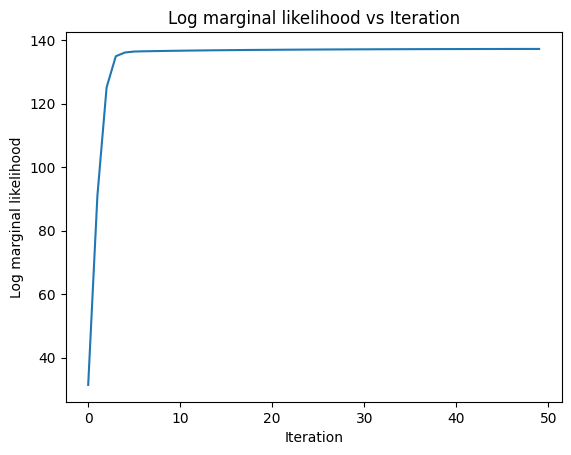

In [51]:
# plot log marginals
plt.plot(log_marginals,label='Estimated log marginal')
# plt.plot(true_logmarginal, label='True log marginal')
plt.xlabel('Iteration')
plt.ylabel('Log marginal likelihood')
plt.title('Log marginal likelihood vs Iteration')

In [52]:
# calculate log marginal over a grid of lengthscales and variances
lengthscales = torch.linspace(0.1, 2, 50)
variances = torch.linspace(0.1, 5, 50)
log_marginals_grid = torch.zeros((len(lengthscales), len(variances)))
for i, lengthscale in enumerate(lengthscales):
    for j, variance in enumerate(variances):
        kernel = SquaredExponential(dimension=1, lengthscale=lengthscale.item(), variance=variance.item())
        log_marginals_grid[i, j] = kernel.log_marginal(x, y, sigmasq)


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/269758788.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[.01, 0, 0.75, 1])


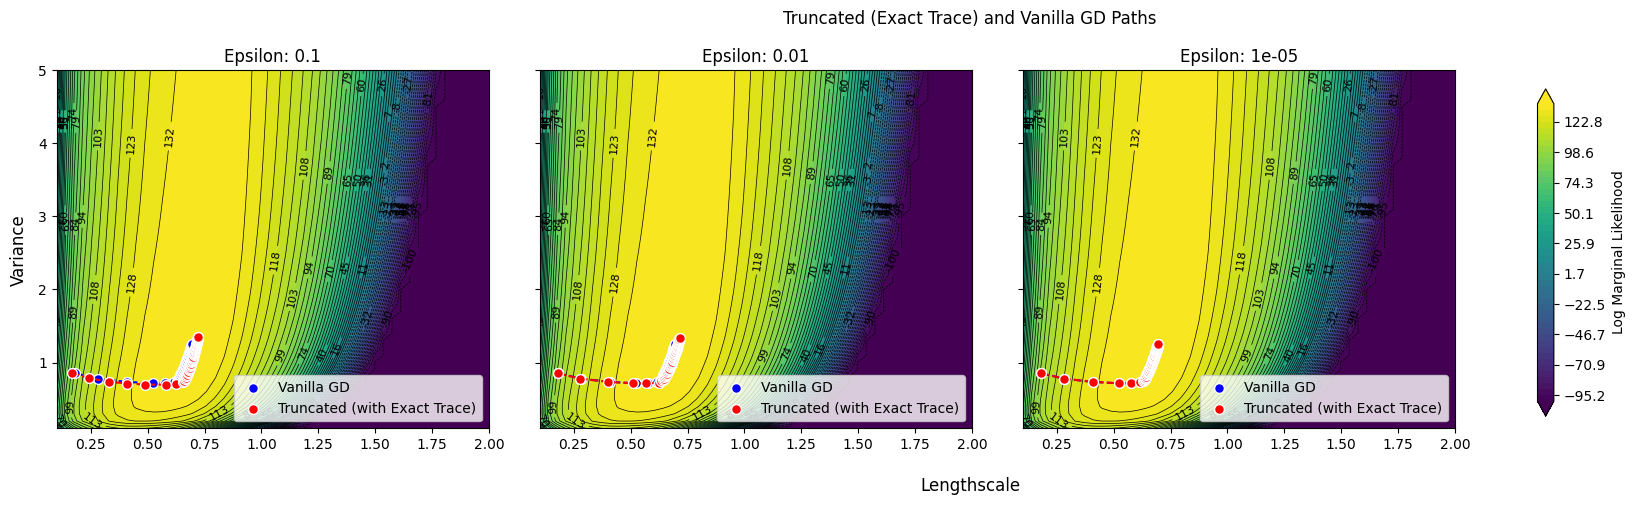

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# For numerical stability, clip extremely low log marginal values.
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())

# Set up detailed filled contour levels and slightly fewer levels for the line overlay.
fill_levels = np.linspace(-100, log_marginals_grid.max(), 50)
line_levels = np.linspace(-100, log_marginals_grid.max(), 50)

# Number of epsilon runs you have in results_exacttrace.
n_plots = len(results_exacttrace)

# Choose a layout: here we use 2 rows and as many columns as needed.
n_rows = 1
n_cols = int(np.ceil(n_plots / n_rows))

# Convert vanilla SGD tracking lists to arrays.
tracked_lengthscales_vanilla_arr = np.array(tracked_lengthscales_vanilla)
tracked_variances_vanilla_arr  = np.array(tracked_variances_vanilla)

# Create a grid of subplots for visualization.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to a 1D list for easy iteration

# Iterate over each subplot (each corresponding to a different epsilon value)
for i, ax in enumerate(axes):
    if i < n_plots:
        # Retrieve the current epsilon run's results.
        res = results_exacttrace[i]
        tracked_lengthscales_path = np.array(res.get('tracked_lengthscales', []))
        tracked_variances_path   = np.array(res.get('tracked_variances', []))
        
        # Plot the filled contours of log marginal likelihood.
        cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T,
                         levels=fill_levels, cmap='viridis', extend='both')
        # Overlay contour lines.
        cs = ax.contour(lengthscales, variances, log_marginal_clipped.T,
                        levels=line_levels, colors='k', linewidths=0.5)
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')
        
        # Plot the vanilla SGD path:
        ax.scatter(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                   color='blue', edgecolors='w', s=50, label='Vanilla GD', zorder=10)
        ax.plot(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                color='blue', linestyle='--', zorder=9)
        
        # Plot the results_exacttrace SGD path for the current epsilon:
        ax.scatter(tracked_lengthscales_path, tracked_variances_path,
                   color='red', edgecolors='w', s=50, label='Truncated (with Exact Trace)', zorder=11)
        ax.plot(tracked_lengthscales_path, tracked_variances_path,
                color='red', linestyle='--', zorder=10)
        
        # Set a title that indicates the epsilon and trace_samples for this run.
        ax.set_title(f"Epsilon: {res['epsilon']}", fontsize=12)
        ax.legend(fontsize=10)
    else:
        # If there is no data to plot in this subplot, hide the axis.
        ax.axis('off')

# Add a colorbar to the entire figure using the last filled contour plot reference (cf).
cbar = fig.colorbar(cf, ax=axes.tolist(), label='Log Marginal Likelihood',
                    shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Label the common x and y axes.
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)

# Adjust layout to fit all subplots and the colorbar nicely.
plt.suptitle('Truncated (Exact Trace) and Vanilla GD Paths')

plt.tight_layout(rect=[.01, 0, 0.75, 1])
plt.show()


# make a figure first that shows that as epsilon goes to 0, then SGD is the same as the vanilla

# next a figure that compares stoch trace estimate w vanilla SGD

/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_21575/211508840.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[.01, 0, 0.75, 1])  # Adjust layout to make space for the colorbar


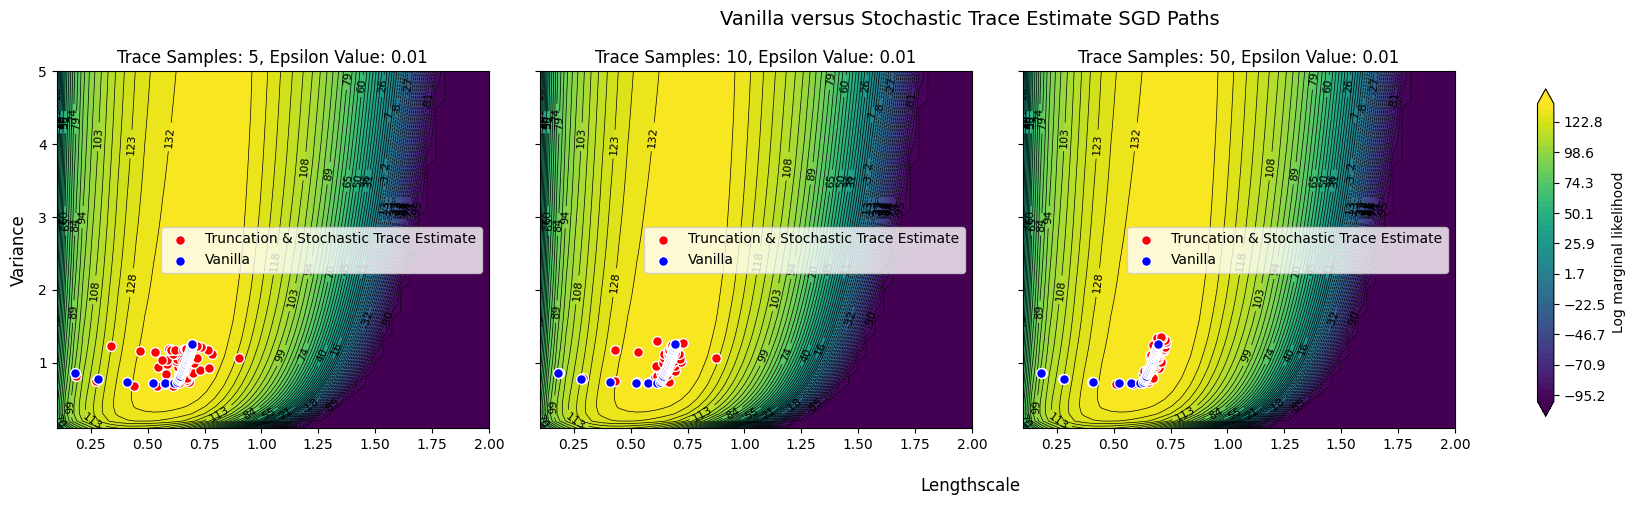

In [54]:

import numpy as np
import matplotlib.pyplot as plt

# Clip values below -100 to prevent extreme low outliers
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())

# Set up filled contour levels (detailed)
fill_levels = np.linspace(-100, log_marginals_grid.max(), 50)
# Use fewer contour levels for the line overlay
line_levels = np.linspace(-100, log_marginals_grid.max(), 50)

# Determine subplot grid dimensions for 2 rows
n_plots = len(results)
n_rows = 1
n_cols = int(np.ceil(n_plots / n_rows))
tracked_lengthscales_vanilla_arr = np.array(tracked_lengthscales_vanilla)
tracked_variances_vanilla_arr = np.array(tracked_variances_vanilla)
# Create a grid of subplots with 2 rows and the required number of columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
# Plot each result in its respective subplot
for i, ax in enumerate(axes):
    # if i < n_plots:  # Only plot if there's data for this subplot
    #     tracked_lengthscales_truncated_arr = tracked_lengthscales_truncated
    #     tracked_variances_truncated_arr = tracked_variances_truncated
    if i < n_plots:  # Only plot if there's data for this subplot
        # Plot filled contours
        cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T,
                         levels=fill_levels, cmap='viridis', extend='both')
        # Overlay a reduced number of contour lines for clarity
        cs = ax.contour(lengthscales, variances, log_marginal_clipped.T,
                        levels=line_levels, colors='k', linewidths=0.5)
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')

        # Overlay tracked hyperparameter points for the current result
        # Ensure tracked_lengthscales and tracked_variances are properly populated
        tracked_lengthscales_arr = np.array(results[i].get('tracked_lengthscales', []))
        tracked_variances_arr = np.array(results[i].get('tracked_variances', []))
        ax.scatter(tracked_lengthscales_arr, tracked_variances_arr,
                   color='red', edgecolors='w', s=50, label='Truncation & Stochastic Trace Estimate', zorder=10)
        # overlay vanilla tracked points

        ax.scatter(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                   color='blue', edgecolors='w', s=50, label='Vanilla', zorder=10)
        
        #overlay truncated tracked points

        # ax.scatter(tracked_lengthscales_truncated_arr, tracked_variances_truncated_arr,
        #            color='green', edgecolors='w', s=50, label='Tracked points (Truncated)', zorder=10)
        # Set title for each subplot
        ax.set_title(f"Trace Samples: {results[i]['trace_samples']}, Epsilon Value: {results[i]['epsilon']}", fontsize=12)
        # add legend
        ax.legend(fontsize=10)

    else:
        # If no data is available for this subplot, turn the axis off.
        ax.axis('off')

# Add a colorbar to the figure, placed outside the subplots
cbar = fig.colorbar(cf, ax=axes.tolist(), label='Log marginal likelihood', shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)
# Label the shared axes
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)
plt.suptitle('Vanilla versus Stochastic Trace Estimate SGD Paths', fontsize=14)
plt.tight_layout(rect=[.01, 0, 0.75, 1])  # Adjust layout to make space for the colorbar
plt.show()


$$\alpha = (K+\sigma^2 I)^{-1}y$$

$$\frac{\partial (K + \sigma^2 I)}{\partial \theta} = FD'F^* + \frac{\partial (\sigma^2 I)}{\partial \theta}$$
where 
$$D'_{jj} = h\frac{\partial }{\partial \theta} \hat{k}_\theta(\xi_j)

# note missing timing in efgp1d